# Introdução às Redes Neurais

In [4]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
class myclass:
    
    def __init__(self, x, y, width=100, debug=False):
        self.Xt_train = x
        self.yt_train = y
        self.Xt_test = x
        self.yt_test = y
        self.report_width = width
        self.graph_width = 1.3 * width // 10
        self.graphs_model = []
        self.debug = debug
        if not self.debug: # remove warnings when not running in debug mode
            import warnings
            warnings.filterwarnings("ignore")
        return None
        
        
    # add a layer of type Dense to an existing model
    def addDense(self, neurons, activation='default', input_dim=0):
        if activation == 'default':
            if input_dim > 0:
                self.model.add(Dense(units=neurons, input_dim=input_dim))
            else:
                self.model.add(Dense(units=neurons))
        else:
            if input_dim > 0:
                self.model.add(Dense(units=neurons, activation=activation, input_dim=input_dim))
            else:
                self.model.add(Dense(units=neurons, activation=activation))
        return None
    
    
    # add a dropout layer to an existing model
    def addDropout(self, perc=0.2):
        self.model.add(Dropout(perc))
        return None


    # create a Sequential topology using the pre defined scheme 
    def topology(self, scheme, loss, optimizer):
        self.model = Sequential()  
        
        # add each layer to the model
        for i, (name, layer) in enumerate(scheme.items()):
            input_dim = 0
            if len(self.model.layers) == 0:
                input_dim = self.Xt_train.shape[1] # set input dim for the first layer
            if i + 1 == len(scheme): # set the number of neurons in the last layer equal len(target)
                self.addDense(self.yt_train.shape[1], layer['activation'], input_dim) 
            else:
                if layer['type'] == 'Dense':
                    self.addDense(layer['neurons'], layer['activation'], input_dim)  
                if len(self.model.layers) != 0 and layer['type'] == 'Dropout':
                    self.addDropout(layer['perc'])  
                    
        # updates the last layer shape to the output shape
        scheme[name].update({'type': layer['type'], 
                                      'neurons': self.yt_train.shape[1],
                                      'activation': layer['activation']})
        # prepare the computational graph for this topology
        self.model.compile(loss=loss, optimizer=optimizer)
        #self.model.summary()
        self.current_scheme = scheme
        #print(scheme)

        return None

    
    # fit and test the performance of the ANN
    def trainANN(self, epochs, verbose):
        x_train = np.asarray(self.Xt_train)
        x_test = np.asarray(self.Xt_test)
        y_train = np.asarray(self.yt_train)
        y_test = np.asarray(self.yt_test)
        try:
            hist = self.model.fit(x=x_train, y=y_train, epochs=epochs, verbose=verbose, validation_split=0.0, shuffle=True)
            loss_and_metrics = self.model.evaluate(x_test, y_test)

            # evaluate the performance of the classifier
            y_pred = self.model.predict(x_test) > 0.5
            score = f1_score(y_test, y_pred)
            accuracy = accuracy_score(y_test, y_pred, normalize=True)
            if score > self.best_f1score:
                self.best_model = self.model
                self.best_scheme = self.current_scheme
                self.best_f1score = score
                self.history = hist.history
                self.y_pred = y_pred
                #print('f1score', score)
                #print('accuracy', accuracy)
                #print('taxa de aprendizado')
                #print('evolucao da acurácia')
                #print('evolucao da loss')
                #print('tempo decorrido')
        except:
            score = 0
        return score
    
    
    # random search for better model performance
    def searchANN(self, runs=1, max_depth=1, fixed={}, printt=True, graph=False):
        size = self.graph_width
        
        # list of optimization options, if not in the fixed dict
        if 'neurons' not in fixed.keys(): 
            neurons_list = [1, 2, 4, 8]
        else:
            neurons_list = fixed['neurons']
            
        if 'loss' not in fixed.keys(): 
            loss_list = ['mean_squared_error', 'mean_absolute_error', 
                         'binary_crossentropy', 'categorical_crossentropy', 'sparse_categorical_crossentropy']
        else:
            loss_list = fixed['loss']
            
        if 'optimizer' not in fixed.keys(): 
            optimizer_list = ['sgd', 'adam', 'adagrad', 'rmsprop']
        else:
            optimizer_list = fixed['optimizer']
            
        if 'epochs' not in fixed.keys(): 
            epoch_list = [5, 100, 500, 1000]
        else:
            epoch_list = fixed['epochs']
            
        if 'type' not in fixed.keys(): 
            type_list = ['Dense', 'Dropout']
        else:
            type_list = fixed['type']
            
        if 'activation' not in fixed.keys(): 
            activation_list = ['sigmoid', 'softmax', 'elu', 'relu']
        else:
            activation_list = fixed['activation']
            
        self.best_model = None
        self.best_f1score = 0.0
        
        # generate the scheme, evaluate and store all relevant results
        names = []
        et = []
        results = []
        model_scheme = []
        losses = []
        optimizers = []
        eps = []
        for run in range(runs):
            start = time.time()
            n_layers = np.random.randint(1, max_depth+1) # random number of layers between 1 and max_depth
            scheme = {}
            for i in range(1, n_layers+1):
                # remove invalid layer types in the first layer
                allowed = [typeof for typeof in type_list if (i != 1 or (typeof != 'Dropout' and i == 1))]
                # remove invalid layer types in the last layer
                allowed = [typeof for typeof in allowed if (i != n_layers or (typeof != 'Dropout' and i == n_layers))]
                layer_type = np.random.choice(allowed)
                if layer_type == 'Dense':
                    scheme.update({'Layer %d'%i: {'type': layer_type, 
                                                  'neurons': np.random.choice(neurons_list),
                                                  'activation': np.random.choice(activation_list)}})
                elif layer_type == 'Dropout':
                    scheme.update({'Layer %d'%i: {'type': layer_type, 
                                                  'perc': np.random.uniform(0.05, 0.5)}})
            
            # prepare the topology for this network
            loss = np.random.choice(loss_list)
            losses.append(loss)
            optimizer = np.random.choice(optimizer_list)
            optimizers.append(optimizer)
            self.topology(scheme, loss, optimizer)
            
            # train and evaluate this topology, compare with previous best and update models if necessary
            epochs = np.random.choice(epoch_list)
            eps.append(epochs)
            score_type = 'f1-score'
            score = self.trainANN(epochs, 0)
            results.append(100 * score)
            model_scheme.append(scheme)
            names.append('Experiment #%d'%(run+1))
            elapsed = (time.time() - start)
            et.append(elapsed)
        report = pd.DataFrame({'Experiment': names, 'Elapsed Time': et, 'Score (f1)': results, 'Model': model_scheme,
                               'Loss': losses, 'Optimizer': optimizers, 'Epochs': eps})
        report.sort_values(by='Score (f1)', ascending=False, inplace=True)
        report.reset_index(inplace=True, drop=True)
        self.report_performance = report
            
        if printt:
            print('\n')
            print(self.report_width * '*', '\n*')
            print('* NEURAL NETWORK RESULTS - BEFORE PARAMETERS BOOSTING \n*')
            print(self.report_width * '*', '')
            display(report)
            print('\n')

        if graph:
            if 'accuracy' in self.history.keys():
                fig, ax = plt.subplots(figsize=(size, 0.5 * size))
                plt.title('Training Evolution')
                plt.plot(self.history['accuracy'])
                if 'val_accuracy' in self.history.keys(): plt.plot(self.history['val_accuracy'])
                plt.xlabel('Epochs')
                plt.ylabel('Accuracy')
                plt.subplots_adjust(hspace=0.0, bottom=0.25)
                self.graphs_model.append(fig)
                plt.show()             
            if 'loss' in self.history.keys():
                fig, ax = plt.subplots(figsize=(size, 0.5 * size))
                plt.title('Training Evolution')
                plt.plot(self.history['loss'])
                if 'val_loss' in self.history.keys(): plt.plot(self.history['val_loss'])
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.subplots_adjust(hspace=0.0, bottom=0.25)
                self.graphs_model.append(fig)
                plt.show()  
                
        y = self.yt_test
        y_pred = self.y_pred
        report = classification_report(y, y_pred, output_dict=True)
        if printt:
            print(self.report_width * '*', '\n*')
            print('* HYPER-PARAMETER TUNING REPORT\n*')
            print("* SCORING METHOD: %s" % score_type)
            print('* BEST F1-SCORE: %.1f' % (100 * self.best_f1score))
            print('* BEST MODEL:', self.best_scheme)
            print('*\n', self.report_width * '*')
            if not graph:
                display(pd.DataFrame(report).T)
            #self.best_model.summary()

        if graph:
            fig, ax = plt.subplots(figsize=(size, 0.3 * size))
            plt.title('Confusion Matrix')
            sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap='YlGn', fmt='d',)
            plt.xlabel('Predicted')
            plt.ylabel('True Class')
            self.graphs_model.append(fig)
            plt.show()
            fig, ax = plt.subplots(figsize=(size, 0.5 * size))
            plt.title('Classification Report')
            sns.heatmap(pd.DataFrame(report).iloc[0:3].T, annot=True, vmin=0, vmax=1, cmap='BrBG', fmt='.2g')
            plt.xlabel('Score')
            self.graphs_model.append(fig)
            plt.show()
            
        return None

### Perceptron OR

4/1 [========================================================================================================================] - 0s 12ms/sample - loss: 11.5687


4/1 [========================================================================================================================] - 0s 12ms/sample - loss: 3.8587


**************************************************************************************************** 
*
* NEURAL NETWORK RESULTS - BEFORE PARAMETERS BOOSTING 
*
**************************************************************************************************** 


,Experiment,Elapsed Time,Score (f1),Model,Loss,Optimizer,Epochs
0,Experiment #99,1.009925,100.000000,"{'Layer 1': {'type': 'Dense', 'neurons': 1, 'a...",mean_squared_error,sgd,1000
1,Experiment #41,0.744221,100.000000,"{'Layer 1': {'type': 'Dense', 'neurons': 1, 'a...",mean_absolute_error,rmsprop,500
2,Experiment #58,0.433852,100.000000,"{'Layer 1': {'type': 'Dense', 'neurons': 1, 'a...",binary_crossentropy,adagrad,5
3,Experiment #77,1.186939,100.000000,"{'Layer 1': {'type': 'Dense', 'neurons': 1, 'a...",binary_crossentropy,adagrad,1000
4,Experiment #51,1.088020,85.714286,"{'Layer 1': {'type': 'Dense', 'neurons': 1, 'a...",mean_squared_error,adagrad,1000
...,...,...,...,...,...,...,...
95,Experiment #64,0.232350,0.000000,"{'Layer 1': {'type': 'Dense', 'neurons': 1, 'a...",sparse_categorical_crossentropy,sgd,100
96,Experiment #65,0.316171,0.000000,"{'Layer 1': {'type': 'Dense', 'neurons': 1, 'a...",sparse_categorical_crossentropy,rmsprop,1000
97,Experiment #34,0.300197,0.000000,"{'Layer 1': {'type': 'Dense', 'neurons': 1, 'a...",sparse_categorical_crossentropy,rmsprop,100
98,Experiment #68,0.269187,0.000000,"{'Layer 1': {'type': 'Dense', 'neurons': 1, 'a...",sparse_categorical_crossentropy,sgd,100


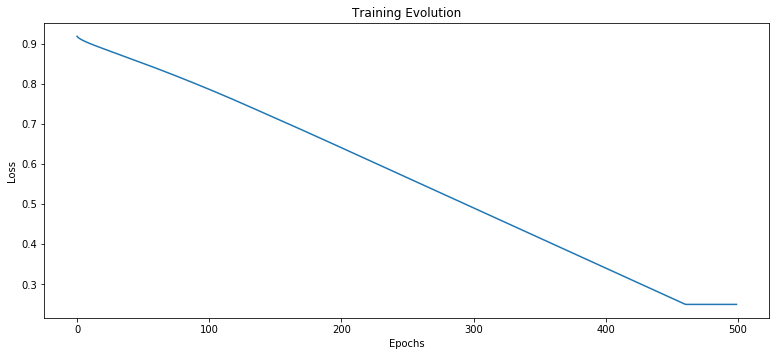

**************************************************************************************************** 
*
* HYPER-PARAMETER TUNING REPORT
*
* SCORING METHOD: f1-score
* BEST F1-SCORE: 100.0
* BEST MODEL: {'Layer 1': {'type': 'Dense', 'neurons': 1, 'activation': 'elu'}}
*
 ****************************************************************************************************


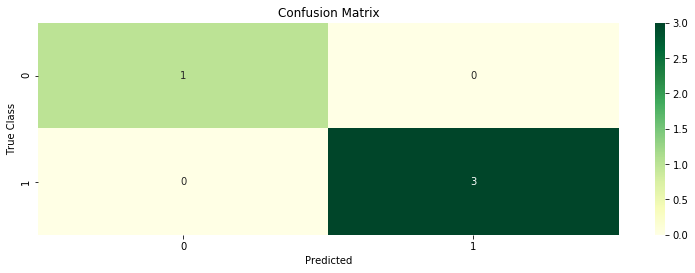

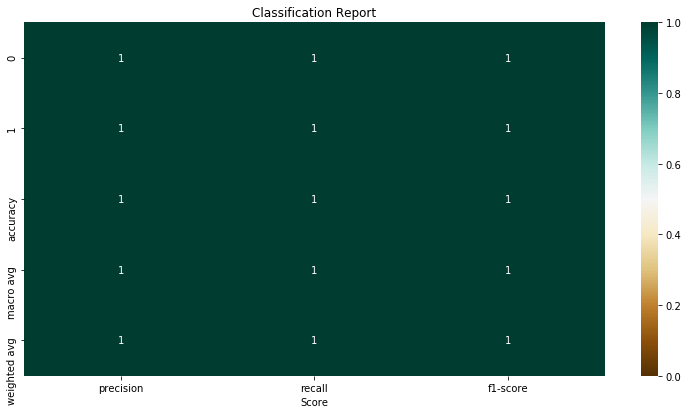

In [40]:
or_truth_table = np.array([[0,0,0],
                           [0,1,1],
                           [1,0,1],
                           [1,1,1]])

X_data = pd.DataFrame(or_truth_table[:,[0,1]])
Y_data = pd.DataFrame(or_truth_table[:,2])

rm = myclass(X_data, Y_data)
rm.searchANN(runs=100, max_depth=1, fixed={'neurons':[1]}, printt=True, graph=True)

### Perceptron AND

4/1 [========================================================================================================================] - 0s 11ms/sample - loss: 0.6053


4/1 [========================================================================================================================] - 0s 11ms/sample - loss: 0.2234


**************************************************************************************************** 
*
* NEURAL NETWORK RESULTS - BEFORE PARAMETERS BOOSTING 
*
**************************************************************************************************** 


,Experiment,Elapsed Time,Score (f1),Model,Loss,Optimizer,Epochs
0,Experiment #37,1.226750,100.0,"{'Layer 1': {'type': 'Dense', 'neurons': 1, 'a...",binary_crossentropy,rmsprop,1000
1,Experiment #48,1.124253,100.0,"{'Layer 1': {'type': 'Dense', 'neurons': 1, 'a...",mean_squared_error,rmsprop,1000
2,Experiment #55,1.201640,100.0,"{'Layer 1': {'type': 'Dense', 'neurons': 1, 'a...",binary_crossentropy,adam,1000
3,Experiment #93,1.242483,100.0,"{'Layer 1': {'type': 'Dense', 'neurons': 1, 'a...",binary_crossentropy,rmsprop,1000
4,Experiment #57,0.724572,100.0,"{'Layer 1': {'type': 'Dense', 'neurons': 1, 'a...",mean_absolute_error,adam,500
...,...,...,...,...,...,...,...
95,Experiment #20,0.028924,0.0,"{'Layer 1': {'type': 'Dense', 'neurons': 1, 'a...",categorical_crossentropy,rmsprop,500
96,Experiment #19,0.030921,0.0,"{'Layer 1': {'type': 'Dense', 'neurons': 1, 'a...",categorical_crossentropy,rmsprop,100
97,Experiment #18,0.501835,0.0,"{'Layer 1': {'type': 'Dense', 'neurons': 1, 'a...",binary_crossentropy,adagrad,100
98,Experiment #70,0.301195,0.0,"{'Layer 1': {'type': 'Dense', 'neurons': 1, 'a...",sparse_categorical_crossentropy,adam,100


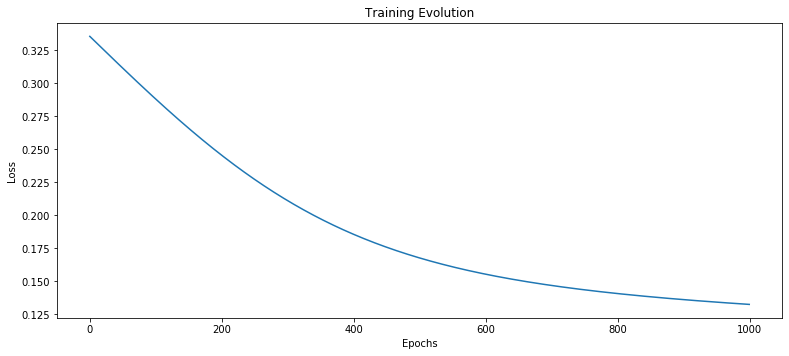

**************************************************************************************************** 
*
* HYPER-PARAMETER TUNING REPORT
*
* SCORING METHOD: f1-score
* BEST F1-SCORE: 100.0
* BEST MODEL: {'Layer 1': {'type': 'Dense', 'neurons': 1, 'activation': 'sigmoid'}}
*
 ****************************************************************************************************


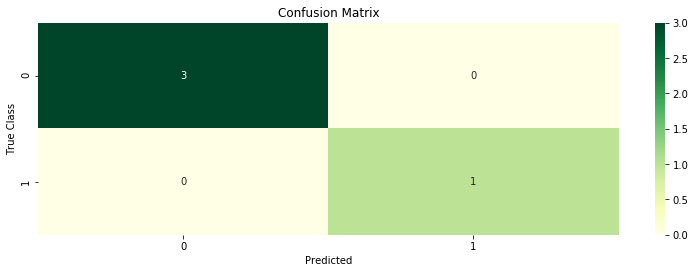

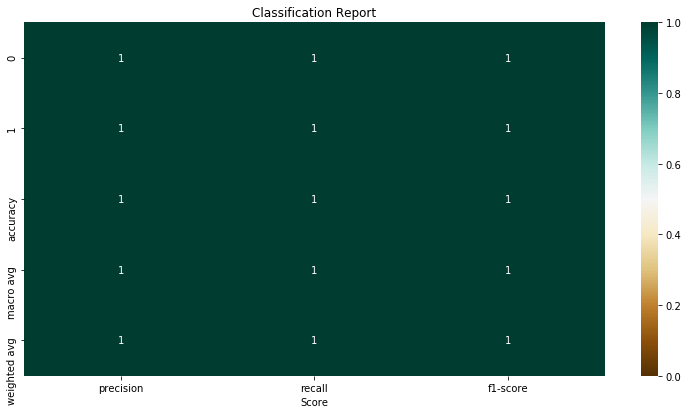

In [41]:
and_truth_table = np.array([[0,0,0],
                            [0,1,0],
                            [1,0,0],
                            [1,1,1]])

X_data = pd.DataFrame(and_truth_table[:,[0,1]])
Y_data = pd.DataFrame(and_truth_table[:,2])

rm = myclass(X_data, Y_data)
rm.searchANN(runs=100, max_depth=1, fixed={'neurons':[1]}, printt=True, graph=True)

### Perceptron XOR

4/1 [========================================================================================================================] - 0s 13ms/sample - loss: 7.7125


4/1 [========================================================================================================================] - 0s 11ms/sample - loss: 0.2147


**************************************************************************************************** 
*
* NEURAL NETWORK RESULTS - BEFORE PARAMETERS BOOSTING 
*
**************************************************************************************************** 


,Experiment,Elapsed Time,Score (f1),Model,Loss,Optimizer,Epochs
0,Experiment #31,1.284279,100.0,"{'Layer 1': {'type': 'Dense', 'neurons': 8, 'a...",mean_squared_error,rmsprop,1000
1,Experiment #8,0.453033,100.0,"{'Layer 1': {'type': 'Dense', 'neurons': 4, 'a...",mean_absolute_error,sgd,100
2,Experiment #40,0.622062,80.0,"{'Layer 1': {'type': 'Dense', 'neurons': 8, 'a...",binary_crossentropy,rmsprop,5
3,Experiment #49,1.187646,80.0,"{'Layer 1': {'type': 'Dense', 'neurons': 1, 'a...",binary_crossentropy,adagrad,1000
4,Experiment #57,0.484858,80.0,"{'Layer 1': {'type': 'Dense', 'neurons': 8, 'a...",binary_crossentropy,sgd,5
...,...,...,...,...,...,...,...
95,Experiment #60,0.385341,0.0,"{'Layer 1': {'type': 'Dense', 'neurons': 2, 'a...",sparse_categorical_crossentropy,adam,500
96,Experiment #61,0.030947,0.0,"{'Layer 1': {'type': 'Dense', 'neurons': 1, 'a...",categorical_crossentropy,adam,500
97,Experiment #24,0.392573,0.0,"{'Layer 1': {'type': 'Dense', 'neurons': 1, 'a...",mean_squared_error,sgd,5
98,Experiment #65,0.303248,0.0,"{'Layer 1': {'type': 'Dense', 'neurons': 1, 'a...",sparse_categorical_crossentropy,rmsprop,5


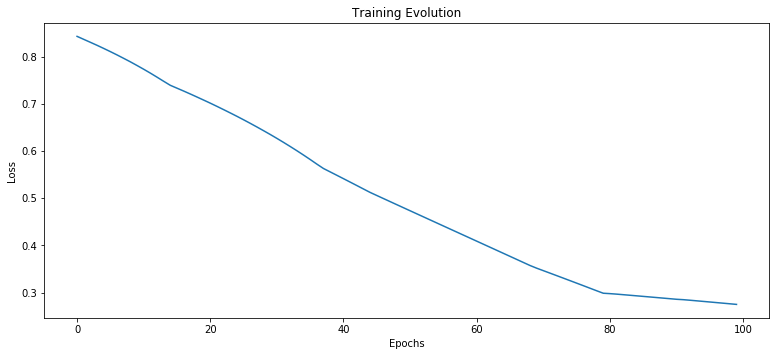

**************************************************************************************************** 
*
* HYPER-PARAMETER TUNING REPORT
*
* SCORING METHOD: f1-score
* BEST F1-SCORE: 100.0
* BEST MODEL: {'Layer 1': {'type': 'Dense', 'neurons': 4, 'activation': 'relu'}, 'Layer 2': {'type': 'Dense', 'neurons': 1, 'activation': 'elu'}}
*
 ****************************************************************************************************


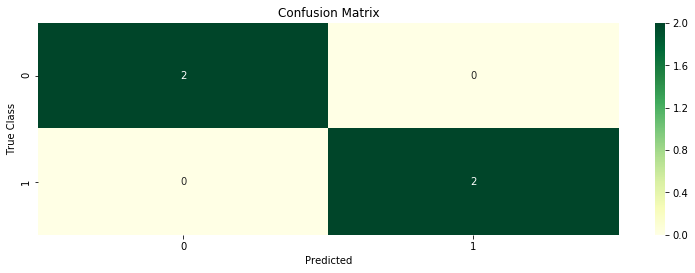

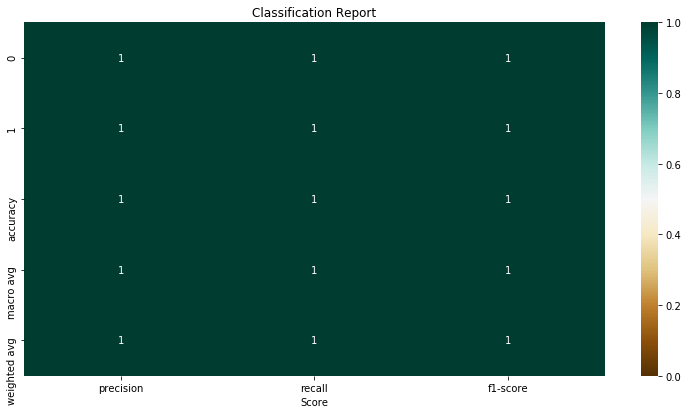

In [42]:
# o perceptron XOR é mais complexo e a rede não consegue aprender usando apenas 1 layer e 1 neurônio
# também vamos liberar o parâmetro de ativação

xor_truth_table = np.array([[0,0,0],
                            [0,1,1],
                            [1,0,1],
                            [1,1,0]])

X_data = pd.DataFrame(xor_truth_table[:,[0,1]])
Y_data = pd.DataFrame(xor_truth_table[:,2])

rm = myclass(X_data, Y_data)
rm.searchANN(runs=100, max_depth=3, fixed={}, printt=True, graph=True)

In [43]:
rm.best_model.summary()

Model: "sequential_1352"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1623 (Dense)           (None, 4)                 12        
_________________________________________________________________
dense_1624 (Dense)           (None, 1)                 5         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# tf.keras.utils.plot_model(rm.best_model, show_shapes=True, show_layer_names=False)